
# Sentiment - Analyser #

The "score" attribute we stored in every comment entry inside our database is already
a ruff estimation of the sentiment of a comment.<br>
However, this score can currently be any number which can vary substantially depending on the number
of likes a comment received... <br>
Besides that there is also the observation that a high like to dislike ratio on
youtube videos is the defacto standard, this is because human being mostly tend
to like positivity. :) <br>
Therefore we need to to the two following things in order to get a "true" sentiment: <br>

- normalize so that the sentiment is between 0 and 1 (for all comments of a video)

- shift the score a little so that a sentiment of 0.7 is more like 0.5

In [1]:
def sentiment_from_score(video_likes, video_dislikes, min_score, max_score, score):
        ratio = float(video_likes)/(float(video_likes)+float(video_dislikes))
        score, min_score, max_score = float(score), float(min_score), float(max_score)
        scaler = max_score - min_score
        if scaler == 0.0 : scaler = 1
        normalized_score = (( score - min_score ) / scaler) / 2
        assert normalized_score <= 0.5 and normalized_score >= 0.0
        capper = min(1, ratio/0.75)**2 
        normalized_score =  capper * 0.5 + normalized_score
        assert normalized_score <= 1 and normalized_score >= 0.0 
        return normalized_score

## Loading Data ##

Before starting with the machine learning and sentiment analysis
we first have to load the data and clean it! <br>
We store the data in the following 5 variables: <br>

- `video_max_comment_score` : A dictionary which ought to hold the largest score per video (of all comments). 

- `video_min_comment_score` : A dictionary which ought to hold the smallest score per video (of all comments).

- `comments` : A list of all comments (included the pre-pended video title).

- `sentiments` : A list of all sentiments calculated from the comment scores.

- `all_words` : A list of all words which will later be counted...

In [2]:

from neo4j import GraphDatabase

uri, user, password = 'bolt://localhost:11005', 'neo4j', 'neo4j_'

driver = GraphDatabase.driver(uri, auth=(user, password))
  
video_max_comment_score = dict()
video_min_comment_score = dict()
comments = []
sentiments = []
all_words = []

with driver.session() as session:
    def _q(query) : return session.run(query)
    #---------------------------------------

    result = _q("MATCH (n:Author)-[c:COMMENTED]->(v:Video) RETURN n, c, v") # remove all graphs and nodes! BE CAREFUL!
 
    records = []

    # First! : We need to do some normalization!
    # Let's find the min/max scores for every video
    for record in result:
        if record['v']['title'] not in video_max_comment_score:
            video_max_comment_score[record['v']['title']] = float(record['c']['score'])
        elif float(video_max_comment_score[record['v']['title']]) > float(record['c']['score']):
            video_max_comment_score[record['v']['title']] = float(record['c']['score'])

        if record['v']['title'] not in video_min_comment_score:
            video_min_comment_score[record['v']['title']] = float(record['c']['score'])
        elif float(video_min_comment_score[record['v']['title']]) < float(record['c']['score']):
            video_min_comment_score[record['v']['title']] = float(record['c']['score'])
            
        if float(record['c']['likes']) > 0 :
            records.append(record)

    for record in records:
        normalized_score = sentiment_from_score(
            record['v']['likes'], 
            record['v']['dislikes'], 
            video_min_comment_score[record['v']['title']], 
            video_max_comment_score[record['v']['title']], 
            record['c']['score']
        )
        sentiments.append(normalized_score)
        
        newComment = (("%s | %s" % (record['v']['title'],record['c']['text'])).lower()
            .replace('❤️', ' heart ').replace('💯', ' 100 ').replace('❤', ' heart ')
            .replace('🙏', ' pray ').replace('😘', ' kiss ').replace('🤗', ' happy ')
            .replace('💥', ' boom ').replace('✔️', ' like ').replace('😍', ' love ')
            .replace('🐱', ' cat ').replace('💔', ' broken heart ').replace('😵', ' confused ') 
            .replace('😄', ' awesome ').replace('👍', ' thumbs up ').replace('😎', ' cool ')
            .replace('🐷', ' pig ').replace('🤘', " rock'n roll ").replace('🤣', ' laughing hard ')
            .replace('😩', ' oh no ').replace('💎', ' diamond ').replace('😊', ' nice ')
            .replace('☺️', ' very nice ').replace('🙃', ' upside down smile ').replace('🤔', ' not sure ')
            .replace('😂', ' laughing ').replace('🙋🏻‍♀️',' hi ').replace('🥰', ' lovely ')
            .replace('!!!!', '!').replace('!!!', '!').replace('!!', '!')
            .replace('????', '?').replace('???', '?').replace('??', '?')
            .replace('oooo','o').replace('oooo','o').replace('ooo','o').replace('oo','o')
            .replace('..','...').replace('......','...').replace('....','...').replace('....','...').replace('...',' ... ')
            .replace('    ', ' ').replace('   ', ' ').replace('  ', ' ')
            .split() 
        )
        #print(newComment, "-|-", float(record['c']['score'])) 
        comments.append(newComment)
        all_words.extend(newComment)
    
    #---------------------------------------
driver.close()
 
#from pprint import pprint
#pprint(comments)
    

In [3]:
print(comments[56])
print(sentiments[56])

['grovy', 'tutorial:', 'learn', 'grovy', 'dsl', 'by', 'example', 'in', '20', 'minutes', '|', 'thanks', 'for', 'sharing', 'your', 'knowledge', '-', 'much', 'appreciated.']
0.9285714285714286


In [4]:
print(comments[79])
print(sentiments[79])

['if', 'programming', 'was', 'an', 'anime', '|', "'time", 'to', 'bring', 'out', 'my', 'secret', "weapon'", 'stackoverflow', 'has', 'entered', 'the', 'chat']
0.9971862391165853


Let's see try to find the comment with the worst sentiment:

In [5]:
worst_i = -1
worst_score = 1
for i, score in enumerate( sentiments ):
    #print(i,score)
    if score < worst_score : 
        worst_score = score
        worst_i = i
        
print(comments[worst_i])
print(sentiments[worst_i])

['asmr*', 'stewed', "dog's", 'thighs.', 'extremely', 'delicious', 'and', 'nutritious(eating', 'sounds)', 'no', 'talking', '|', 'vi', 'asmr', '|', 'coi', 'chừng', 'bị', 'quật', 'á', 'chị,', 'gì', 'mà', 'ăn', 'chó', 'mèo', 'không', 'vậy?', 'chị', 'có', 'còn', 'là', 'con', 'người', 'ko', 'vậy?']
0.018602992696261058


## Clean the Comments with Spark ##

The comments are currently still full of redundancies and
many uncommon tokens / words.
In order to be able to filter the comments we use spark to count their occurrences. <br>
After that we can remove the uncommon ones...

In [6]:
from pyspark import SparkContext
 
sc = SparkContext("local", "First App")
 
wordsRDD = sc.parallelize(all_words, 6)

zipped = (wordsRDD
            .map(lambda word : (word,1))
            .reduceByKey( lambda a, b : a+b )
            .collect())
sc.stop()                  

occurrences = {}

for word, count in zipped:
    occurrences[word] = count

print('Total number of unique words:', len(occurrences))

Total number of unique words: 4149


...and now let's remove rare tokens / words in order to cap the maximum amount of possible words a bit...

In [7]:

def more_than_three(word):
    return occurrences[word] > 3

for i, comment in enumerate(comments): 
    comments[i] = list(filter(more_than_three, comment))

We also filter all comments which are under and over a certain size
in order to make training easier. <br>
Then we store the cleaned data into the following variables: <br>

- `clean_comments`

- `clean_sentiments`

In [8]:

def removed_short_comments(all_comments, all_sentiments):
    new_comments, new_sentiments = [], []
    
    for i, comment in enumerate(all_comments): 
        if len(comment) > 12 and len(comment) < 32 :
            new_comments.append(comment)
            new_sentiments.append(all_sentiments[i])
        
    return new_comments, new_sentiments

print('Number of comments before trimming:',len(comments))
print('Number of sentiments before trimming:',len(sentiments))

clean_comments, clean_sentiments = removed_short_comments(comments, sentiments)

print('Number of comments after trimming:',len(clean_comments))
print('Number of sentiments after trimming:',len(clean_sentiments))


Number of comments before trimming: 685
Number of sentiments before trimming: 685
Number of comments after trimming: 493
Number of sentiments after trimming: 493


In [9]:
print(clean_comments)

[['sentiment', 'analysis', 'python', '-', '1', '-', 'introduction', 'to', 'emotion', 'analysis', '(nlp)', '|', 'great', 'series'], ['sentiment', 'analysis', 'python', '-', '1', '-', 'introduction', 'to', 'emotion', 'analysis', '(nlp)', '|', 'please', '2', '3', 'videos'], ['sentiment', 'analysis', 'python', '-', '1', '-', 'introduction', 'to', 'emotion', 'analysis', '(nlp)', '|', 'your', 'game', 'tutorial', 'is', 'hope', 'to', 'see', 'more', 'videos', 'on', 'python', 'during'], ['sentiment', 'analysis', 'python', '-', '1', '-', 'introduction', 'to', 'emotion', 'analysis', '(nlp)', '|', 'love', 'the', 'lol'], ['sentiment', 'analysis', 'python', '-', '3', '-', 'for', 'language', '(nlp)', '|', 'hey', 'man', 'long', 'time', '!'], ['sentiment', 'analysis', 'python', '-', '3', '-', 'for', 'language', '(nlp)', '|', 'thank', 'you', '...'], ['sentiment', 'analysis', 'python', '-', '4', '-', 'tokenization', 'and', 'stop', 'words', '(nlp)', '|', 'love', 'it,', 'keep', 'it'], ['sentiment', 'analysi

---

# Sentiment Analysis with Pytorch #

Let's train a neural network on our data!

In [10]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

## 1. Defining an LSTM Recurrent Neural Network Model ##

- `Xt` : Vectorized word at sentence index `t`

- `ht` : Output of lstm at sentence index `t`

![](images/lstm_illustration.webp)

In [11]:
# src/inspiration: https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
class LSTMScorePredictor(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim, actifun='softmax'):
        super(LSTMScorePredictor, self).__init__() 
        self.hidden_dim = hidden_dim
        self.actifun = actifun

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
            
        # The linear layer that maps from hidden state space to tag space
        self.lin = nn.Linear(hidden_dim, output_dim)

    def forward(self, sentence): 
        #print('sentence: ', sentence)
        embeds = self.word_embeddings(sentence)
        #print(embeds.shape)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        out = self.lin(lstm_out.view(len(sentence), -1))
        if self.actifun == 'softmax' : out = F.log_softmax(out, dim=1)
        elif self.actifun == 'sigmoid' : out = F.sigmoid(out) 
        
        return out

## 2. Word - Index encoding ##

PyTorch comes with a built in utility which encodes a given word index (from a total list of unique words)
into a fixed sized vector which represents that index (and thereby also the word).<br>
This utility is the one we already used inside the model, namely: `nn.Embedding(vocab_size, embedding_dim)`<br>

The `vocab_size` is the size of the total number of unique words and the `embedding_dim` is the size 
of the vectors which ought to encode a given index... <br>

So what we now need to do is a mapping between unique words and their unque indexes.<br>
The following class fulfills that role:

In [12]:

# Word to index encoding...
class Encoder:
    
    def __init__(self, training_data):
        self.word_to_ix = dict()
        # For each words-list (sentence) and tags-list in each tuple of training_data
        for sent, label in training_data:
            for word in sent:
                if word not in self.word_to_ix:  # word has not been assigned an index yet
                    self.word_to_ix[word] = len(self.word_to_ix)  # Assign each word with a unique index
        #print(self.word_to_ix)
        self.label_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index

    def sequence_words(self, seq):
        idxs = [self.word_to_ix[w] for w in seq]
        return torch.tensor(idxs, dtype=torch.long)
    
    
    def sequence_labels(self, seq):
        idxs = [self.label_to_ix[w] for w in seq]
        return torch.tensor(idxs, dtype=torch.long)

## 3. Training Setup ##

Now we define a method which created and trains a LSTM-Model based on a set of passed configuration parameters...

In [58]:
import matplotlib.pyplot as plt

def exec_trial(
    training_data, 
    loss_function=None, 
    optimizer=None,
    epochs=300,
    do_label_encode=True,
    actifun='softmax', 
    embedding_dim=6, # These will usually be more like 32 or 64 dimensional.
    hidden_dim=6,# We will keep them small, so we can see how the weights change as we train.
    enc=None,
    step_every_word=True
):
    torch.manual_seed(42) 
    if enc == None: enc = Encoder(training_data)
        
    if not do_label_encode: output_dim = 1
    else: output_dim = len(enc.label_to_ix)
    
    model = LSTMScorePredictor(
        embedding_dim=embedding_dim, 
        hidden_dim=hidden_dim, 
        vocab_size=len(enc.word_to_ix), 
        output_dim=output_dim,
        actifun=actifun
    )
    if loss_function == 'mse': loss_function = nn.MSELoss()
    elif loss_function == None: loss_function = nn.NLLLoss()
    
    if optimizer == 'adam': optimizer = optim.Adam(model.parameters(), lr=0.0001)
    elif optimizer == None: optimizer = optim.SGD(model.parameters(), lr=0.1)
  
    losses = []
    word_losses = []
    for epoch in range(epochs):  
        if not step_every_word: 
            model.zero_grad() 
            
        for sentence, tags in training_data: 
            if step_every_word :
                model.zero_grad() 
                
            sentence_in = enc.sequence_words(sentence)
            if do_label_encode: targets = enc.sequence_labels(tags)
            else: targets = tags 
            tag_scores = model(sentence_in) 
            loss = loss_function(tag_scores, targets)
            loss.backward()
            word_losses.append(loss.item())
            if step_every_word:
                optimizer.step()
                
        if not step_every_word:
            optimizer.step()
            
        losses.append( loss.item() )
            
        print('Epoch',epoch, 'loss =',loss.item())
    print('Trial done! \n===========') 
    #plt.plot(losses)
    #plt.ylabel('Training Loss')
    #plt.show()
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4)) 
    fig.suptitle('Horizontally stacked subplots')
    ax1.plot(losses, 'tab:green')
    ax2.plot(word_losses, 'tab:blue')
    ax1.set_title('Epoch Losses')
    ax2.set_title('Word Losses') 
    return model

### 3.1 Unit-Testing the Model: ###

This is already a lot of code... <br>
Let's do some unit testing in order to make the defined logic more robust.

Epoch 0 loss = 1.1654255390167236
Epoch 1 loss = 1.1565314531326294
Epoch 2 loss = 1.148512840270996
Epoch 3 loss = 1.141252040863037
Epoch 4 loss = 1.134647011756897
Epoch 5 loss = 1.1286096572875977
Epoch 6 loss = 1.1230638027191162
Epoch 7 loss = 1.1179441213607788
Epoch 8 loss = 1.1131938695907593
Epoch 9 loss = 1.1087646484375
Epoch 10 loss = 1.1046143770217896
Epoch 11 loss = 1.1007071733474731
Epoch 12 loss = 1.0970114469528198
Epoch 13 loss = 1.0935003757476807
Epoch 14 loss = 1.0901503562927246
Epoch 15 loss = 1.086941123008728
Epoch 16 loss = 1.0838547945022583
Epoch 17 loss = 1.0808758735656738
Epoch 18 loss = 1.0779906511306763
Epoch 19 loss = 1.0751869678497314
Epoch 20 loss = 1.0724540948867798
Epoch 21 loss = 1.0697824954986572
Epoch 22 loss = 1.0671638250350952
Epoch 23 loss = 1.0645900964736938
Epoch 24 loss = 1.0620546340942383
Epoch 25 loss = 1.0595508813858032
Epoch 26 loss = 1.0570732355117798
Epoch 27 loss = 1.0546163320541382
Epoch 28 loss = 1.0521754026412964
Ep

Epoch 244 loss = 0.07896509766578674
Epoch 245 loss = 0.07790349423885345
Epoch 246 loss = 0.07686430960893631
Epoch 247 loss = 0.07584697008132935
Epoch 248 loss = 0.07485097646713257
Epoch 249 loss = 0.07387590408325195
Epoch 250 loss = 0.07292123138904572
Epoch 251 loss = 0.07198630273342133
Epoch 252 loss = 0.07107098400592804
Epoch 253 loss = 0.07017450034618378
Epoch 254 loss = 0.06929653882980347
Epoch 255 loss = 0.06843660026788712
Epoch 256 loss = 0.06759430468082428
Epoch 257 loss = 0.06676913052797318
Epoch 258 loss = 0.0659608244895935
Epoch 259 loss = 0.06516876816749573
Epoch 260 loss = 0.06439273059368134
Epoch 261 loss = 0.06363218277692795
Epoch 262 loss = 0.06288691610097885
Epoch 263 loss = 0.06215636804699898
Epoch 264 loss = 0.06144030764698982
Epoch 265 loss = 0.06073833256959915
Epoch 266 loss = 0.06005008891224861
Epoch 267 loss = 0.059375207871198654
Epoch 268 loss = 0.05871344357728958
Epoch 269 loss = 0.058064401149749756
Epoch 270 loss = 0.057427823543548584

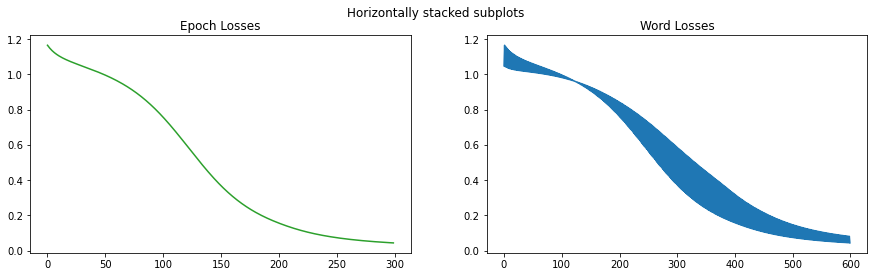

In [60]:
 
# Example training data:
training_data = [ 
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
enc = Encoder(training_data)

model = exec_trial(training_data, enc=enc)

# See what the scores are after training
with torch.no_grad():
    inputs = enc.sequence_words(training_data[0][0])
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(inputs)
    print(tag_scores)
    
assert str(inputs) == """tensor([0, 1, 2, 3, 4])"""
assert str(tag_scores) == """tensor([[-0.0259, -4.5027, -4.2358],
        [-4.5316, -0.0617, -3.0154],
        [-2.6551, -2.9622, -0.1301],
        [-0.1583, -3.9917, -2.0562],
        [-4.2915, -0.0241, -4.5954]])"""


print('Unit test successful! :)')

Epoch 0 loss = 0.26555222272872925
Epoch 1 loss = 0.26313287019729614
Epoch 2 loss = 0.2607865333557129
Epoch 3 loss = 0.2585119605064392
Epoch 4 loss = 0.25630760192871094
Epoch 5 loss = 0.25417202711105347
Epoch 6 loss = 0.2521035671234131
Epoch 7 loss = 0.25010067224502563
Epoch 8 loss = 0.24816171824932098
Epoch 9 loss = 0.24628493189811707
Epoch 10 loss = 0.24446865916252136
Epoch 11 loss = 0.2427111566066742
Epoch 12 loss = 0.24101075530052185
Epoch 13 loss = 0.23936571180820465
Epoch 14 loss = 0.2377743124961853
Epoch 15 loss = 0.2362349033355713
Epoch 16 loss = 0.23474577069282532
Epoch 17 loss = 0.23330527544021606
Epoch 18 loss = 0.2319118082523346
Epoch 19 loss = 0.23056377470493317
Epoch 20 loss = 0.22925961017608643
Epoch 21 loss = 0.2279978096485138
Epoch 22 loss = 0.2267768681049347
Epoch 23 loss = 0.22559532523155212
Epoch 24 loss = 0.22445175051689148
Epoch 25 loss = 0.2233448624610901
Epoch 26 loss = 0.22227324545383453
Epoch 27 loss = 0.22123558819293976
Epoch 28 los

Epoch 287 loss = 0.09229002892971039
Epoch 288 loss = 0.09169769287109375
Epoch 289 loss = 0.09110985696315765
Epoch 290 loss = 0.09052658081054688
Epoch 291 loss = 0.08994783461093903
Epoch 292 loss = 0.0893736407160759
Epoch 293 loss = 0.08880403637886047
Epoch 294 loss = 0.08823900669813156
Epoch 295 loss = 0.08767853677272797
Epoch 296 loss = 0.08712264895439148
Epoch 297 loss = 0.0865713357925415
Epoch 298 loss = 0.08602461218833923
Epoch 299 loss = 0.08548241853713989
Epoch 300 loss = 0.08494479954242706
Epoch 301 loss = 0.08441172540187836
Epoch 302 loss = 0.08388318866491318
Epoch 303 loss = 0.08335915207862854
Epoch 304 loss = 0.08283963054418564
Epoch 305 loss = 0.08232459425926208
Epoch 306 loss = 0.08181402087211609
Epoch 307 loss = 0.08130788803100586
Epoch 308 loss = 0.0808061808347702
Epoch 309 loss = 0.08030886948108673
Epoch 310 loss = 0.07981595396995544
Epoch 311 loss = 0.07932737469673157
Epoch 312 loss = 0.07884310185909271
Epoch 313 loss = 0.07836314290761948
Epoc

AssertionError: 

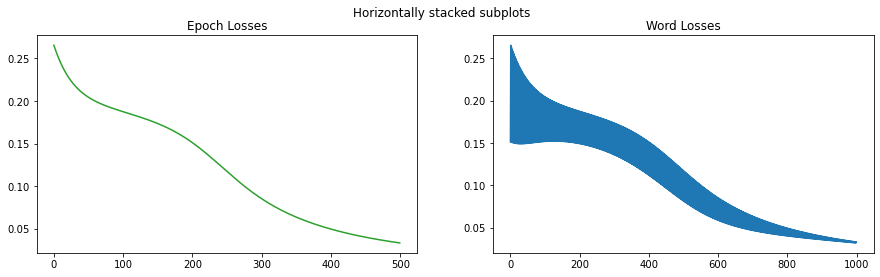

In [61]:
# Test training data: 
training_data = [ 
    ("The dog ate the apple".split(), torch.tensor([[1], [0], [0.5], [0.3], [1]])),
    ("Everybody read that book".split(), torch.tensor([[[0.2], [0], [1], [0]]]))
]
enc = Encoder(training_data)
model = exec_trial(
    training_data, 
    loss_function='mse', 
    do_label_encode=False,
    actifun='sigmoid',
    epochs=500,
    enc=enc
)
      
# See what the scores are after training
with torch.no_grad():
    inputs = enc.sequence_words(training_data[0][0])
    pred1 = model(inputs) 
    inputs = enc.sequence_words(training_data[1][0])
    pred2 = model(inputs)
          
#print(hash(str(pred1.cpu().detach().numpy())), hash(str(pred2.cpu().detach().numpy())))
assert hash(str(pred1.cpu().detach().numpy())) == 2423810420677829124#8299978301676431484
assert hash(str(pred2.cpu().detach().numpy())) == -5139078890918265923#4865758014180741225

print('Unit test successful! :)')

## 4. Training and Predicting the Sentiment Score ##

Let's split our data 80% traing and 20% test data...

In [64]:
import random 

def list_splitter(list_to_split, ratio):
    elements = len(list_to_split)
    middle = int(elements * ratio)
    return [list_to_split[:middle], list_to_split[middle:]]


clean_training_data = []

for i, comment in enumerate(clean_comments):
    clean_training_data.append(
        (comment, torch.tensor([[clean_sentiments[i]]]*len(comment)))
    )
    
random.Random(66642999).shuffle(clean_training_data)
    
train, test = list_splitter(clean_training_data, 0.8)

print('Train / Test split:', len(train),'/',len(test))

Train / Test split: 394 / 99


Now we are ready to train it!

Epoch 0 loss = 0.07998403906822205
Epoch 1 loss = 0.0747351124882698
Epoch 2 loss = 0.07473503798246384
Epoch 3 loss = 0.07473497837781906
Epoch 4 loss = 0.07473490387201309
Epoch 5 loss = 0.07473485171794891
Epoch 6 loss = 0.07473477721214294
Epoch 7 loss = 0.07473471760749817
Epoch 8 loss = 0.0747346580028534
Epoch 9 loss = 0.07473457604646683
Trial done! 
Epoch 0 loss = 0.014130444265902042
Epoch 1 loss = 0.016481729224324226
Epoch 2 loss = 0.016614645719528198
Epoch 3 loss = 0.016509396955370903
Epoch 4 loss = 0.016381006687879562
Epoch 5 loss = 0.01625622808933258
Epoch 6 loss = 0.016139868646860123
Epoch 7 loss = 0.016033438965678215
Epoch 8 loss = 0.015937073156237602
Epoch 9 loss = 0.015849828720092773
Trial done! 
Epoch 0 loss = 0.07998403906822205
Epoch 1 loss = 0.07993500679731369
Epoch 2 loss = 0.07988593727350235
Epoch 3 loss = 0.07983681559562683
Epoch 4 loss = 0.07978767156600952
Epoch 5 loss = 0.07973849028348923
Epoch 6 loss = 0.07968925684690475
Epoch 7 loss = 0.07964

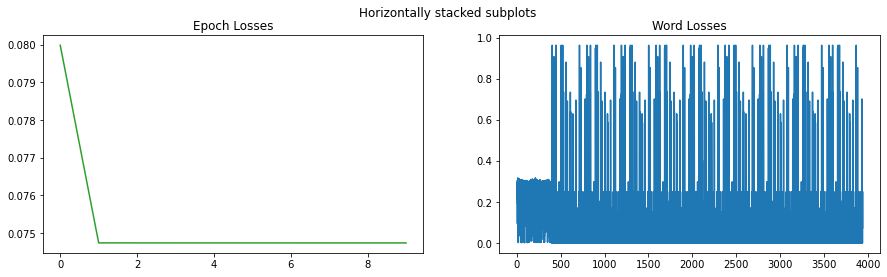

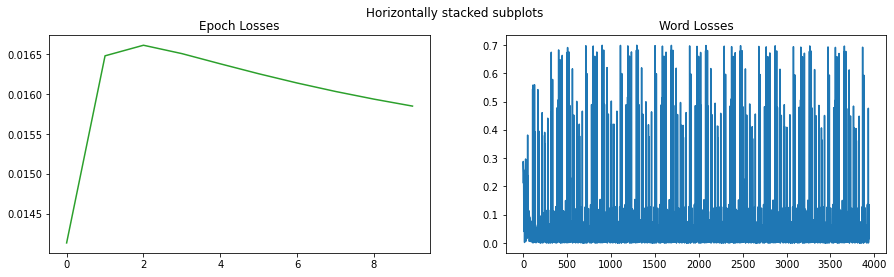

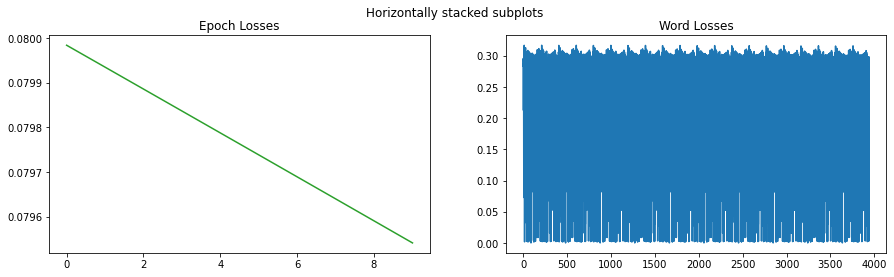

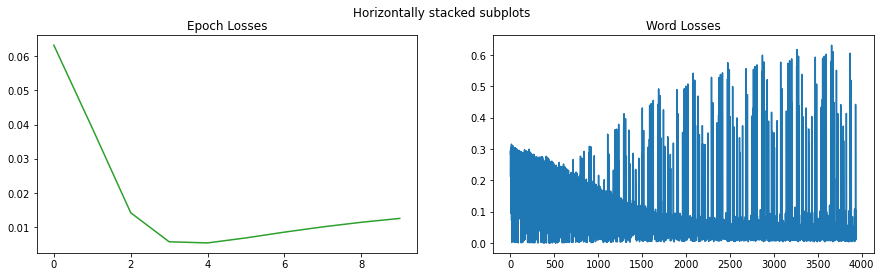

In [65]:

    
enc = Encoder(clean_training_data)
    
model = exec_trial(
    training_data=train, 
    loss_function='mse', 
    do_label_encode=False,
    actifun='sigmoid',
    epochs=10,
    enc=enc,
    step_every_word=False
)

model = exec_trial(
    training_data=train, 
    loss_function='mse', 
    do_label_encode=False,
    actifun='sigmoid',
    epochs=10,
    enc=enc,
    step_every_word=True
)

#...

model = exec_trial(
    training_data=train, 
    loss_function='mse', 
    do_label_encode=False,
    actifun='sigmoid',
    epochs=10,
    enc=enc,
    step_every_word=False,
    optimizer='adam'
)

model = exec_trial(
    training_data=train, 
    loss_function='mse', 
    do_label_encode=False,
    actifun='sigmoid',
    epochs=10,
    enc=enc,
    step_every_word=True,
    optimizer='adam'
)
#result = model.eval(test)
#print(result)


In [18]:
val_losses = []
loss_function = nn.MSELoss()

with torch.no_grad():
    for x_val, y_val in test: 
        model.eval() 
        sentence_in = enc.sequence_words(x_val)
        yhat = model(sentence_in)
        val_loss = loss_function(y_val, yhat)
        val_losses.append(val_loss.item())
        print(' '.join(x_val),'\n-=> ',yhat.mean().item(),' should be ',y_val.mean().item(),'\n')

joe rants about la coronavirus shutdowns | they are not they are all taking part in a big the great they are 
-=>  0.8215108513832092  should be  0.9968957901000977 

andrew ng: deep learning, education, and real-world ai | lex fridman podcast #73 | i tok class on years it my from to and my in making awesome to see this 
-=>  0.8381901383399963  should be  0.6809523701667786 

every programming tutorial | you forgot the part where you say about this for 
-=>  0.811745285987854  should be  0.5 

every programming tutorial | 'you know how it of i don't that's why i'm here 
-=>  0.8150385618209839  should be  0.9979152679443359 

joe rants about la coronavirus shutdowns | the part is when they get they no at all. 
-=>  0.8027494549751282  should be  0.7011085748672485 

anita sarkeesian on gamergate and sexism | the scarlet letter reports | and anita what a great 
-=>  0.8092634081840515  should be  0.14086699485778809 

die karte der mathematik | that moment when your math is on the same

 ---
 
 # Doing some good old Logistic Regression #
 
 
 ## 1. Bag of Words ##
 
 Although we already cleaned your data very thoroughly, for this approach we need
 to go even further! <br>
 We are going to use the `nltk` library in order to remove so called **"stopword"**, 
 which are very commen words that don not carry significant meaning...<br>
 ...and we are also going to convert the remaining words into their root form so that we reduce
 the noise in our data even more!<br>
 
In the English language, words can take multiple different forms depending upon where and how we use them. 
Lemmatizing is a process of bringing all different forms of a word to its root form so that machine looks at them as similar words.

For example- {‘keep’, ‘keeping’, ‘keeper’, ‘keeps’} will be reduced to a single word-‘keep’. 

In [71]:
import re
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
lemmatizer = nltk.stem.WordNetLemmatizer()

english_stop_words = nltk.corpus.stopwords.words('english')
print('Stop word in the english language:',len(english_stop_words))
print("'Let's take a look at a couple:\n")
print(' | '.join(english_stop_words[:25]),'...')


def keep_only_letters(word):
    word=re.sub(r'[^a-zA-Z\s]','',word)
    return word
 
def convert_to_lowercase(word):
    return word.lower()
 
def remove_stop_word(word):
    for stopword in english_stop_words:
        if word == stopword:
            return None
    return word

def lemmatize_word(word):
    #stemmer = nltk.porter.PorterStemmer()
    #stemmed = stemmer.stem(word)
    lemmared = lemmatizer.lemmatize(word)
    return lemmared
    
def clean_comment_further(text): 
    cleaned = []
    for word in text:
        word = keep_only_letters(word)
        word = convert_to_lowercase(word)
        word = remove_stop_word(word)
        if word != None and word != '' : 
            word = lemmatize_word(word)
            cleaned.append(word)
    return cleaned
 

Stop word in the english language: 179
'Let's take a look at a couple:

i | me | my | myself | we | our | ours | ourselves | you | you're | you've | you'll | you'd | your | yours | yourself | yourselves | he | him | his | himself | she | she's | her | hers ...


Now that we defined the methods for polishing the data, we now apply them and create carrier variables, namely:


- `train_X`, `train_Y` 
- `test_X`, `test_Y` 

Previously the training and test data we used for our neural networ
was a list of tuples which contained the X and Y values... <br>
Now we want to work with scikit-learn models so we have to convert these<br>
train test lists to these new variables: 

In [66]:
train_X, train_Y = [], []
test_X, test_Y = [], []

for x, y in train: 
    train_X.append(' '.join(clean_comment_further(x)))
    train_Y.append(y.mean().item())
    
for x, y in test:
    test_X.append(' '.join(clean_comment_further(x)))
    test_Y.append(y.mean().item())
  
print('Number of comments for training:',len(train_X))
print('Number of comments for testing:',len(test_X))

Number of comments for training: 394
Number of comments for testing: 99


...hardly readable for us, but easy to encode for the computer! :)

## 2. Vectorization & Training ##

Now we use a vectorizer from the scikit-learn library to encode the text data...<br>
Then we binarize the sentiments and fit the `sklearn.linear_model.LogisticRegression()` model!

In [24]:

import sklearn
import sklearn.feature_extraction
import sklearn.linear_model

vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))

tf_features_train = vectorizer.fit_transform(train_X)
tf_features_test = vectorizer.transform(test_X)
print('Feature shapes of train / test arrays:',tf_features_train.shape,'/', tf_features_test.shape)

train_labels = [1 if sentiment > 0.9 else 0 for sentiment in train_Y]
test_labels = [1 if sentiment > 0.9 else 0 for sentiment in test_Y]
print('Number of train & test labels: ',len(train_labels),'/', len(test_labels))

clf = sklearn.linear_model.LogisticRegression()
clf.fit(tf_features_train, train_labels)
print ('Model used:',clf)

Feature shapes of train / test arrays: (394, 410) / (99, 410)
Number of train & test labels:  394 / 99
Model used: LogisticRegression()


## 3. Evaluation #

Finally we do some predictions and calculate informative metrics for them!

In [26]:
predictions = clf.predict(tf_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1]))

              precision    recall  f1-score   support

    Negative       0.72      0.41      0.52        32
    Positive       0.77      0.93      0.84        67

    accuracy                           0.76        99
   macro avg       0.74      0.67      0.68        99
weighted avg       0.75      0.76      0.74        99

[[13 19]
 [ 5 62]]


The accuracy is not bad, especially because of the fact that the amouont of data we used was rather small...<br>
Let's look at the binary predictions:

In [27]:
print(predictions)

[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]


---

# Associating sentiments with words! #

The bag of words approach we tested previously leads us to another
strategy, based on the following question: <br>

- What if we calculate a fixed sentiment for every word?

Doing so would allow us to create a dictionary of words with an associated
sentiment. <br>
This dictionary could then be used to predict the sentiment of
whole sentences by simply calculating the average of the sentiments
of the words of a given sentence... <br>
Just like the previous approach this would ignore grammer as well
as the real meaning of a given sentence. <br>
However, for simple comments which contain words like "hate", "love", "good", "bad"... 
this approach might actually yield very good results!<br>

**Let's try it out!**

First we define a method which calculates a word-sentiment dictionary:

In [30]:

def train_word_sentiments(X, Y):
    word_sentiments = dict()
    for i, sentence in enumerate(X):
        words = sentence.split()
        sentiment = Y[i]
        for word in words:
            if word not in word_sentiments:
                word_sentiments[word] = (1, sentiment)
            else:
                count, accum_sent = word_sentiments[word]
                word_sentiments[word] = (count+1, accum_sent+sentiment)   
    final_word_sentiments = dict()
    for word, data in word_sentiments.items():
        count, accum_sent = data
        final_word_sentiments[word] = accum_sent / count
        
    return final_word_sentiments


Then we define a method which can do predictions based on such a dictionary:

In [31]:
def predict_sentence_by_words(word_sentiments, X, Y):
    pred = []
    for i, sentence in enumerate(X):
        words = sentence.split()
        sentiment = Y[i]
        sentiment_pred = 0
        count = 0
        for word in words:
            if word in word_sentiments:
                count += 1
                sentiment_pred += word_sentiments[word]
        
        if count>0 : pred.append(sentiment_pred/count)
        else : pred.append(0.5)
    return pred

And lastly, we train and test the concept with the previously 
created data, namely: <br>

- `train_X`, `train_Y` 
- `test_X`, `test_Y` 

In [33]:
    
word_sentiments = train_word_sentiments(train_X, train_Y)
predictions = predict_sentence_by_words(word_sentiments, test_X, test_Y)

loss = 0
for i, pred in enumerate(predictions):
    print(test_X[i],'\n-=> ',pred,' should be ',test_Y[i])
    loss += abs(pred-test_Y[i])
loss = loss / len(predictions)
print('====================================')
print('| Average loss:', loss)
print('====================================')

joe rant la coronavirus shutdown taking part big great 
-=>  0.8898634318488049  should be  0.9968957901000977
andrew ng deep learning education realworld ai lex fridman podcast tok class year making awesome see 
-=>  0.9059233804733984  should be  0.6809523701667786
every programming tutorial forgot part say 
-=>  0.9015563957450482  should be  0.5
every programming tutorial know dont thats im 
-=>  0.9056123990515333  should be  0.9979152679443359
joe rant la coronavirus shutdown part get 
-=>  0.8896058741419307  should be  0.7011085748672485
anita sarkeesian gamergate sexism scarlet letter report anita great 
-=>  0.2641536768385844  should be  0.14086699485778809
die karte der mathematik moment math level 
-=>  0.9006221272169598  should be  0.997488796710968
surprising girlfriend new puppy love life 
-=>  0.9235334802216096  should be  0.9991401433944702
programming anime becomes becomes 
-=>  0.9492185694475969  should be  0.8596305251121521
january sale bean mr bean funny clip 

**This approach works surprisingly well!**